In [37]:
import model
import numpy as np
import random
import tank
import truck

import gym_pdsystem

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import animation, rc
import matplotlib.patches as mpatches

from IPython.display import HTML

import pandas as pd
import time

from gym_pdsystem.envs.pdsystem_env import PDSystemEnv
import gym_pdsystem.utils.utilsq as ut
import gym_pdsystem.utils.constants as ct
import gym_pdsystem.utils.functions as fnc

import os

simulations_directory = './simulations'
if not os.path.exists(simulations_directory):
    os.makedirs(simulations_directory)


In [2]:
COEFF = ct.COEFF

C_TRANSPORT = ct.C_TRANSPORT
C_LEVELS = ct.C_LEVELS

p0_GLOBAL = ct.p0_GLOBAL

P1_GLOBAL = ct.P1_GLOBAL
P2_GLOBAL = ct.P2_GLOBAL

M_GLOBAL = ct.M_GLOBAL

NOT_DELIVERYING_PENALTY = P2_GLOBAL #to be equivalent/same importance as having 0 stock or surpassing max capacity levels


## System initializer

In [3]:
def initialize_test_system(seed = None):
    if seed != None:
        np.random.seed(seed)

    # Tanks' information
    global n
    n = 5 
    tank_ids = list(range(1,n+1))
    tank_max_loads =  np.array([100., 200, 100., 800., 200.])
    C_max = np.array([ [load] for load in tank_max_loads ])

    tank_current_loads = np.full(n,0)
    tank_consumption_rates =  np.array([5.] * n)
    noisy_consumption_rate = False
    
    global n_discrete_load_levels
    n_discrete_load_levels = np.array([4,4,4,4,4])
    
    load_level_percentages = np.array([ #b , c, e
                                            [0.02, 0.31, 0.9],
                                            [0.01, 0.03, 0.9],
                                            [0.05, 0.16, 0.9],
                                            [0.07, 0.14, 0.85],
                                            [0.08, 0.26, 0.9]
                                               ])
    for i in range(n):
        tank_consumption_rates[i] = tank_max_loads[i] * (load_level_percentages[i][0] + load_level_percentages[i][1])/2.0
        
    tank_levels = np.multiply(C_max,load_level_percentages)
    
    for i, tank_level in enumerate(tank_levels):
                a = tank_level[0]
                b = tank_level[-1]
                #current_load = 0.75 * (a+b)/2.0# np.random.randint(a+1,b, size =(1,)) GIVES A STRANGE ERROR
                current_load = np.random.random() * (b - a-1) + a+1 #np.random.randint(a+1,b)
                tank_current_loads[i] = current_load * 1.0
                
#     for i, (lvl, max_load) in enumerate(zip(n_discrete_load_levels, tank_max_loads)):
#         a = np.linspace(0,max_load, lvl+1)[1]
#         current_load = np.random.randint(a+1,max_load)
#         tank_current_loads[i] = current_load     

    # Trucks' information
    global k
    k = 2
    truck_ids = list(range(k))
    truck_max_loads = np.array([70.,130.])
    truck_current_loads = truck_max_loads.copy()
    truck_current_positions =  np.array([5] * k)
    #truck_fractions_deliverable =  np.array([1.] * k) # we for now we only allow to deliver all the content of the truck
    truck_fractions_deliverable =  np.array([ np.array([1.]), 
                                              np.array([1.])
                                            ]) # we for now we only allow to deliver all the content of the truck
    global n_discrete_load_levels_trucks
    n_discrete_load_levels_trucks = np.array([1,1])

    # System's information
   
    graph = ut.simple_graph(n+1)
    tanks = [tank.Tank( tank_id, current_load, max_load, consumption_rate, n_lvls, d_lvls, noisy_consumption_rate) 
             for  tank_id, current_load, max_load, consumption_rate, n_lvls, d_lvls in 
             zip( tank_ids, tank_current_loads, tank_max_loads, tank_consumption_rates, n_discrete_load_levels,
                  load_level_percentages)]
    trucks = [truck.Truck( truck_id, current_load, max_load, current_position, load_fractions_deliverable, n_lvls) 
             for  truck_id, current_load, max_load, current_position, load_fractions_deliverable, n_lvls in 
             zip(truck_ids, truck_current_loads, truck_max_loads, truck_current_positions, 
                 truck_fractions_deliverable, n_discrete_load_levels_trucks)]

    w =  np.array([32., 159., 162., 156.,156., 0.])

    weights_matrix = ut.simple_weights(n+1, w)
    
    return(tanks, trucks, graph, weights_matrix)

tanks, trucks, graph, weights_matrix = initialize_test_system()
toy_system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)

# Action-State space dimension
a_s_dim = toy_system.states_dim * toy_system.actions_dim
a_s_dim

368640

In [4]:
tanks, trucks, graph, weights_matrix = initialize_test_system(seed = 42)
system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)
print(system.tank_loads())
print(system.graph)
print(system.weights)

[35, 171, 67, 429, 42]
[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [1 1 1 1 1 1]]
[[ inf  inf  inf  inf  inf  inf]
 [ inf  inf  inf  inf  inf  inf]
 [ inf  inf  inf  inf  inf  inf]
 [ inf  inf  inf  inf  inf  inf]
 [ inf  inf  inf  inf  inf  inf]
 [ 32. 159. 162. 156. 156.   0.]]


### Reinitialize system function

In [5]:
def reinitialize_system(system, seed = None):
    if seed != None:
        np.random.seed(seed)
        
    for tank, tank_levels in zip(system.tanks, system.tanks_level):
        a = tank_levels[0]
        b = tank_levels[-1]
        current_load = np.random.random() * (b - a-1) + a+1 #np.random.randint(a+1,b)*1.0
        tank.load = current_load
    system.reset_trucks_positions(); 
    return(system)    

## Q-learning algorithm (off-policy)


### Training

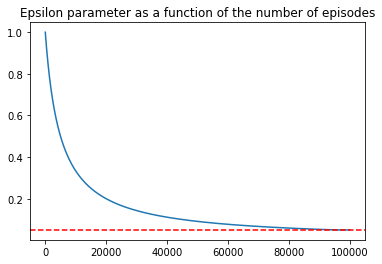

In [6]:
# Retrain parameters:
retrain = False

episode_retrain = 2*10**3 # episode number from which start the retrain. Ensure that a file with this number in 
                          # the Q filename is available.
retrain_episodes = 1*10**3


# Train parameters:
train_epsilon = True

learning_rate0 = 1 
learning_rate_decay = 0 

episode_length = 30
discount_rate = 0.9

episodes = 1*10**5
episodes_epsilon_min = 0.05*episodes

# Output's frequencies
train_freq = 10**2 # 10**4
train_vis_freq =  np.inf #10**3
train_rew_freq =  10**2
train_Q_freq =  10**3

epsilon0 = 1.0
epsilon_decay =( 1./(episodes_epsilon_min) ) 
epsilon_min = 0.05

verbose = False
verbose_info = False

seed = 42

simulation_id = 17

# Visualization of the epsilon parameter value that will be present duing the simulation
% matplotlib inline

def epsilon_fnc(x, epsilon0 = epsilon0, decay = epsilon_decay, epsilon_min = epsilon_min):
    e_mins = epsilon_min * np.ones(len(x))
    eps = epsilon0 / (1.0 + (x-1)*epsilon_decay)
    return np.maximum(e_mins, eps )

t = np.arange(1, episodes, 1)
epsilon = epsilon_fnc(t)

plt.plot(t, epsilon)
plt.axhline(y= epsilon_min, xmin=0, xmax=episodes, hold=None, color = "Red", linestyle = '--')

plt.title("Epsilon parameter as a function of the number of episodes");

In [7]:
train_visualization_steps = []
train_rewards_list = []

tanks, trucks, graph, weights_matrix = initialize_test_system()
toy_system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)

Q = {}

# Create directories for the simulations' outputs

simulation_directory = './simulations/simulation{}'.format(simulation_id)
if not os.path.exists(simulation_directory):
    os.makedirs(simulation_directory)
    os.makedirs(simulation_directory + '/Q-dictionaries')
    os.makedirs(simulation_directory + '/discrewards')
    os.makedirs(simulation_directory + '/vis')
    
else:
    raise Exception("The simulation id you tried to use has been already used before. Try to change it to a new one.")

    
ut.save_obj(toy_system, simulation_directory+"/system-sim"+f"{simulation_id}") 

rewards_file = simulation_directory+'/discrewards'+ '/rewards-sim{}.csv'.format(simulation_id)
states_file = simulation_directory+'/vis'+ '/states-sim{}.csv'.format(simulation_id) # for testing

# Output headers to file
with open(rewards_file,'w') as f:
     np.savetxt(f, [["episode", "discreward"]], fmt="%s", delimiter=',')         


In [8]:
def episodic_train_Q_epsilon( 
            epsilon0 = epsilon0,
            epsilon_min = epsilon_min,
            n_episodes = episodes, 
            episode_length = episode_length,
            learning_rate0 = learning_rate0,
            learning_rate_decay = learning_rate_decay,
            discount_rate = discount_rate,
            system = toy_system,
            Q = Q, verbose = verbose, verbose_info = verbose_info,
            visualization_steps = train_visualization_steps, rewards_list = train_rewards_list,
            seed = seed, 
            freq = train_freq,
            vis_freq = train_vis_freq,
            rew_freq = train_rew_freq,
            Q_freq = train_Q_freq,
            simulation_id = simulation_id,
            round_time = 2
    
           ):
    
    time_start = time.time()
    
    for episode in range(1,n_episodes+1):
        print("\rEpisode: {}".format(episode), end="")

        reinitialize_system(system, seed = episode)
        
        ### epsilon-greedy exploration
        epsilon = max( epsilon_min, epsilon0 / (1+(episode-1)*epsilon_decay) ) 
        
        ### decrement of learning rate
        learning_rate = learning_rate0 / (1+(episode-1)*learning_rate_decay)        

        discounted_reward = 0
        
        for t in range(episode_length):

            system.update_state()
            s_current = system.state_to_string()                
            p = np.random.uniform()

            if p > epsilon:
                #DETERMINISTIC ACTION OPTIMAL
                s0 = system.state_to_string()
                best_action = optimal_policy(s0, Q)
                if best_action == None:
                    reward = system.random_action(seed = (seed + (t+1)*episode), verbose = verbose)
                else:
                    reward = system.deterministic_action(best_action)
                #print(best_action)
            else:
                reward = system.random_action(seed = (seed + (t+1)*episode), verbose = verbose)

            a_current = system.action_to_string()
            sa_current = ''.join([s_current, a_current])

            system.update_state()
            sa_new = system.state_action_to_string()

            if ut.is_key(Q, sa_current) == False:
                Q[sa_current] = 0

            Q_max = max([Q[key] for key in Q.keys() if key.startswith(sa_new[0:system.state_length])]+[0.0]) 

            if Q[sa_current] != -np.inf:
                Q[sa_current] = ( (1-learning_rate) * Q[sa_current] 
                                 + learning_rate* (reward + discount_rate * Q_max)
                                )
                
            discounted_reward = discounted_reward + (discount_rate**t) * reward
            system.reset_trucks_positions();     
            system.reset_trucks_loads();
            
        #rewards_list.append(discounted_reward);
        if episode % freq == 0:
                time_end = time.time()
                print(". Elapsed time ", round( (time_end-time_start)/60., round_time), " minuts.",
                      "epsilon", round(epsilon,4), 
                     "Discounted reward: ", discounted_reward)
                
                if verbose_info:
                    print("s, a", system.s, system.a)
                    print("ds, da", system.ds, system.da)
        if episode % Q_freq == 0:           
                ut.save_obj(Q, simulation_directory +"/Q-dictionaries/Q-dict-sim" + f"{simulation_id}" + "-" + f"{episode}")   

        if episode % vis_freq == 0:
                #Save visualization and rewards
                visualization_steps.append(toy_system.visualize());
                ut.save_obj(visualization_steps, simulation_directory +"/vis/vis-train-sim" + f"{simulation_id}" + "-" + f"{episode}")   
                                
        if episode % rew_freq == 0:
                #rewards_list.append(discounted_reward);
                #ut.save_obj(rewards_list, simulation_directory +"/discrewards/discrew-train-sim" + f"{simulation_id}" + "-" + f"{episode}")
                # Output data to files
                with open(rewards_file,'ab') as f:
                    np.savetxt(f, [np.array([episode, discounted_reward])], fmt=("%d",'%.10f'), delimiter=',')    
        
    end_time = round(time.time()-time_start,round_time)        
    print(f"Training finished. Total episodes: {n_episodes}. Elapsed time: {round(end_time/60., round_time)} minutes.")        

In [9]:
# Given a state, returns the action that has the highest Q-value.

def optimal_policy(state, Q, system = toy_system):
    """
    state must be in the string-integers code
    """
    state_keys = [key for key in list(Q) if key.startswith(state)]
    if len(state_keys) == 0:
        return(None)
    
    state_q = [Q[state_key] for state_key in state_keys]
    
    #print("state_q ", state_q[1:min(10,len(state_q))])
    
    max_q = max(state_q)
    #print("max_q", max_q)
    optimal_key_index = np.where(np.isin(state_q, max_q ))[0][0]
    #print("optimal_key_index", optimal_key_index)
    optimal_key = state_keys[optimal_key_index]
    #print("optimal_key", optimal_key)
    optimal_action = optimal_key[system.state_length:]
    
    return(optimal_action)
    

In [10]:
if train_epsilon == True and retrain == False:
    episodic_train_Q_epsilon()
elif train_epsilon == False and retrain == True:
    Q_retrain = ut.load_obj(simulation_directory + "/Q-dictionaries/Q-dict-sim" + f"{simulation_id}" + "-" + f"{episode_retrain}")
    episodic_train_Q_epsilon(n_episodes = retrain_episodes, Q = Q_retrain)
else:
    raise Exception("Only one of the parameters train_epsilon or retrain parameters can be set to True.")
    
    

Episode: 100. Elapsed time  0.05  minuts. epsilon 0.9806 Discounted reward:  -19.142010170934775
Episode: 200. Elapsed time  0.11  minuts. epsilon 0.9617 Discounted reward:  -16.29820762625509
Episode: 300. Elapsed time  0.18  minuts. epsilon 0.9436 Discounted reward:  -18.020414506150097
Episode: 400. Elapsed time  0.28  minuts. epsilon 0.9261 Discounted reward:  -14.608881338869995
Episode: 500. Elapsed time  0.38  minuts. epsilon 0.9093 Discounted reward:  -17.627632576365762
Episode: 600. Elapsed time  0.5  minuts. epsilon 0.893 Discounted reward:  -16.058735560131844
Episode: 700. Elapsed time  0.61  minuts. epsilon 0.8773 Discounted reward:  -16.560652813047817
Episode: 800. Elapsed time  0.72  minuts. epsilon 0.8622 Discounted reward:  -17.622391383444032
Episode: 900. Elapsed time  0.85  minuts. epsilon 0.8476 Discounted reward:  -15.014769490261157
Episode: 1000. Elapsed time  0.99  minuts. epsilon 0.8335 Discounted reward:  -16.0702661171396
Episode: 1100. Elapsed time  1.12 

Episode: 16800. Elapsed time  52.82  minuts. epsilon 0.2294 Discounted reward:  -2.135845342545334
Episode: 16900. Elapsed time  53.25  minuts. epsilon 0.2283 Discounted reward:  -2.429776984294022
Episode: 17000. Elapsed time  53.69  minuts. epsilon 0.2273 Discounted reward:  -2.4358300322054474
Episode: 17100. Elapsed time  54.14  minuts. epsilon 0.2263 Discounted reward:  -5.881040616186354
Episode: 17200. Elapsed time  54.59  minuts. epsilon 0.2252 Discounted reward:  -1.6946511813271081
Episode: 17300. Elapsed time  55.04  minuts. epsilon 0.2242 Discounted reward:  -3.0188149492201437
Episode: 17400. Elapsed time  55.5  minuts. epsilon 0.2232 Discounted reward:  -4.633196133206589
Episode: 17500. Elapsed time  55.95  minuts. epsilon 0.2222 Discounted reward:  -3.50213679855324
Episode: 17600. Elapsed time  56.38  minuts. epsilon 0.2212 Discounted reward:  -7.590128632741632
Episode: 17700. Elapsed time  56.81  minuts. epsilon 0.2203 Discounted reward:  -6.420329095375324
Episode: 

Episode: 25100. Elapsed time  90.12  minuts. epsilon 0.1661 Discounted reward:  -1.1991759621381066
Episode: 25200. Elapsed time  90.6  minuts. epsilon 0.1656 Discounted reward:  -4.031867398520383
Episode: 25300. Elapsed time  91.03  minuts. epsilon 0.165 Discounted reward:  -1.6256135982004971
Episode: 25400. Elapsed time  91.48  minuts. epsilon 0.1645 Discounted reward:  -0.49139276076409766
Episode: 25500. Elapsed time  91.93  minuts. epsilon 0.1639 Discounted reward:  -1.6217263293632367
Episode: 25600. Elapsed time  92.39  minuts. epsilon 0.1634 Discounted reward:  -2.3504365771826885
Episode: 25700. Elapsed time  92.82  minuts. epsilon 0.1629 Discounted reward:  -3.107350734039795
Episode: 25800. Elapsed time  93.26  minuts. epsilon 0.1623 Discounted reward:  -1.9971162528739914
Episode: 25900. Elapsed time  93.7  minuts. epsilon 0.1618 Discounted reward:  -1.56514889850598
Episode: 26000. Elapsed time  94.14  minuts. epsilon 0.1613 Discounted reward:  -2.8868470567494047
Episod

Episode: 33300. Elapsed time  127.64  minuts. epsilon 0.1306 Discounted reward:  -1.9939463006044233
Episode: 33400. Elapsed time  128.13  minuts. epsilon 0.1302 Discounted reward:  -1.0262465050146572
Episode: 33500. Elapsed time  128.59  minuts. epsilon 0.1299 Discounted reward:  -4.943413193888605
Episode: 33600. Elapsed time  129.04  minuts. epsilon 0.1295 Discounted reward:  -1.668022223815319
Episode: 33700. Elapsed time  129.49  minuts. epsilon 0.1292 Discounted reward:  -2.7141687212818906
Episode: 33800. Elapsed time  129.95  minuts. epsilon 0.1289 Discounted reward:  -3.0697525812671613
Episode: 33900. Elapsed time  130.47  minuts. epsilon 0.1285 Discounted reward:  -0.6218541413255227
Episode: 34000. Elapsed time  130.94  minuts. epsilon 0.1282 Discounted reward:  -1.586595780466594
Episode: 34100. Elapsed time  131.41  minuts. epsilon 0.1279 Discounted reward:  -0.8288061160378204
Episode: 34200. Elapsed time  131.88  minuts. epsilon 0.1276 Discounted reward:  -0.2983435629

Episode: 41500. Elapsed time  170.89  minuts. epsilon 0.1075 Discounted reward:  -0.005873848431058701
Episode: 41600. Elapsed time  171.52  minuts. epsilon 0.1073 Discounted reward:  -2.220087888150306
Episode: 41700. Elapsed time  172.15  minuts. epsilon 0.1071 Discounted reward:  -5.441643111183514
Episode: 41800. Elapsed time  172.79  minuts. epsilon 0.1068 Discounted reward:  -1.5985545164671568
Episode: 41900. Elapsed time  173.42  minuts. epsilon 0.1066 Discounted reward:  -3.2038688080862814
Episode: 42000. Elapsed time  174.06  minuts. epsilon 0.1064 Discounted reward:  -1.5617625891038058
Episode: 42100. Elapsed time  174.75  minuts. epsilon 0.1062 Discounted reward:  -0.50870643834991
Episode: 42200. Elapsed time  175.34  minuts. epsilon 0.1059 Discounted reward:  -3.3036484711250185
Episode: 42300. Elapsed time  175.97  minuts. epsilon 0.1057 Discounted reward:  -0.2025970239367366
Episode: 42400. Elapsed time  176.6  minuts. epsilon 0.1055 Discounted reward:  -2.4214138521

Episode: 49700. Elapsed time  211.69  minuts. epsilon 0.0914 Discounted reward:  -0.8213261596222582
Episode: 49800. Elapsed time  212.17  minuts. epsilon 0.0912 Discounted reward:  -0.18516747924256458
Episode: 49900. Elapsed time  212.63  minuts. epsilon 0.0911 Discounted reward:  -0.8618681049552636
Episode: 50000. Elapsed time  213.08  minuts. epsilon 0.0909 Discounted reward:  -0.0036071026556799496
Episode: 50100. Elapsed time  213.56  minuts. epsilon 0.0907 Discounted reward:  -3.2860231468033465
Episode: 50200. Elapsed time  214.01  minuts. epsilon 0.0906 Discounted reward:  -0.001939300659883536
Episode: 50300. Elapsed time  214.46  minuts. epsilon 0.0904 Discounted reward:  -3.316499450676136
Episode: 50400. Elapsed time  214.91  minuts. epsilon 0.0903 Discounted reward:  -1.8177638285391302
Episode: 50500. Elapsed time  215.38  minuts. epsilon 0.0901 Discounted reward:  -1.7830153335383372
Episode: 50600. Elapsed time  215.83  minuts. epsilon 0.0899 Discounted reward:  -1.72

Episode: 57900. Elapsed time  250.76  minuts. epsilon 0.0795 Discounted reward:  -0.4017113968249498
Episode: 58000. Elapsed time  251.24  minuts. epsilon 0.0794 Discounted reward:  -2.2168246066047064
Episode: 58100. Elapsed time  251.75  minuts. epsilon 0.0792 Discounted reward:  -0.9065639646481057
Episode: 58200. Elapsed time  252.27  minuts. epsilon 0.0791 Discounted reward:  -2.0976781150519095
Episode: 58300. Elapsed time  252.76  minuts. epsilon 0.079 Discounted reward:  -0.004259732886353432
Episode: 58400. Elapsed time  253.28  minuts. epsilon 0.0789 Discounted reward:  -0.2607611308742033
Episode: 58500. Elapsed time  253.75  minuts. epsilon 0.0787 Discounted reward:  -0.4116174583704478
Episode: 58600. Elapsed time  254.21  minuts. epsilon 0.0786 Discounted reward:  -2.2016762417122955
Episode: 58700. Elapsed time  254.73  minuts. epsilon 0.0785 Discounted reward:  -0.08476666524666877
Episode: 58800. Elapsed time  255.22  minuts. epsilon 0.0784 Discounted reward:  -0.99347

Episode: 66100. Elapsed time  293.52  minuts. epsilon 0.0703 Discounted reward:  -1.5806533938359266
Episode: 66200. Elapsed time  294.05  minuts. epsilon 0.0702 Discounted reward:  -1.2629749675350124
Episode: 66300. Elapsed time  294.64  minuts. epsilon 0.0701 Discounted reward:  -0.12616985905041767
Episode: 66400. Elapsed time  295.17  minuts. epsilon 0.07 Discounted reward:  -0.4889070879260611
Episode: 66500. Elapsed time  295.72  minuts. epsilon 0.0699 Discounted reward:  -1.0442250515511382
Episode: 66600. Elapsed time  296.24  minuts. epsilon 0.0698 Discounted reward:  -0.0041122435006611295
Episode: 66700. Elapsed time  296.75  minuts. epsilon 0.0697 Discounted reward:  -0.23208365112056106
Episode: 66800. Elapsed time  297.33  minuts. epsilon 0.0696 Discounted reward:  -0.3386947752320998
Episode: 66900. Elapsed time  297.87  minuts. epsilon 0.0695 Discounted reward:  -0.005693531019535274
Episode: 67000. Elapsed time  298.39  minuts. epsilon 0.0694 Discounted reward:  -2.03

Episode: 82300. Elapsed time  378.99  minuts. epsilon 0.0573 Discounted reward:  -0.25737065023325645
Episode: 82400. Elapsed time  379.47  minuts. epsilon 0.0572 Discounted reward:  -0.21132513376125084
Episode: 82500. Elapsed time  380.02  minuts. epsilon 0.0571 Discounted reward:  -0.6210306916899778
Episode: 82600. Elapsed time  380.51  minuts. epsilon 0.0571 Discounted reward:  -4.982688566041836
Episode: 82700. Elapsed time  381.0  minuts. epsilon 0.057 Discounted reward:  -0.6476183195363931
Episode: 82800. Elapsed time  381.58  minuts. epsilon 0.0569 Discounted reward:  -1.1351023900463995
Episode: 82900. Elapsed time  382.06  minuts. epsilon 0.0569 Discounted reward:  -0.43536303193598214
Episode: 83000. Elapsed time  382.6  minuts. epsilon 0.0568 Discounted reward:  -0.27205673361768007
Episode: 83100. Elapsed time  383.11  minuts. epsilon 0.0568 Discounted reward:  -2.230500070265964
Episode: 83200. Elapsed time  383.59  minuts. epsilon 0.0567 Discounted reward:  -0.88416731

Episode: 90400. Elapsed time  420.35  minuts. epsilon 0.0524 Discounted reward:  -0.015552390131117306
Episode: 90500. Elapsed time  420.93  minuts. epsilon 0.0524 Discounted reward:  -0.003560161639155107
Episode: 90600. Elapsed time  421.46  minuts. epsilon 0.0523 Discounted reward:  -1.0695217288929586
Episode: 90700. Elapsed time  421.94  minuts. epsilon 0.0522 Discounted reward:  -2.0056491944880817
Episode: 90800. Elapsed time  422.44  minuts. epsilon 0.0522 Discounted reward:  -0.33432741949096795
Episode: 90900. Elapsed time  423.0  minuts. epsilon 0.0521 Discounted reward:  -0.9632147277591548
Episode: 91000. Elapsed time  423.5  minuts. epsilon 0.0521 Discounted reward:  -0.6619936069504267
Episode: 91100. Elapsed time  424.05  minuts. epsilon 0.052 Discounted reward:  -0.5506835014580196
Episode: 91200. Elapsed time  424.52  minuts. epsilon 0.052 Discounted reward:  -0.9483268941927278
Episode: 91300. Elapsed time  425.0  minuts. epsilon 0.0519 Discounted reward:  -1.0372122

Episode: 98600. Elapsed time  462.2  minuts. epsilon 0.05 Discounted reward:  -1.5249729270429309
Episode: 98700. Elapsed time  462.69  minuts. epsilon 0.05 Discounted reward:  -0.6516579639200979
Episode: 98800. Elapsed time  463.17  minuts. epsilon 0.05 Discounted reward:  -0.8788364248514788
Episode: 98900. Elapsed time  463.65  minuts. epsilon 0.05 Discounted reward:  -0.0630915667231521
Episode: 99000. Elapsed time  464.13  minuts. epsilon 0.05 Discounted reward:  -0.006101705827228608
Episode: 99100. Elapsed time  464.65  minuts. epsilon 0.05 Discounted reward:  -0.005761990688302863
Episode: 99200. Elapsed time  465.15  minuts. epsilon 0.05 Discounted reward:  -0.0032299871470972594
Episode: 99300. Elapsed time  465.65  minuts. epsilon 0.05 Discounted reward:  -0.9661905035920062
Episode: 99400. Elapsed time  466.25  minuts. epsilon 0.05 Discounted reward:  -0.0034493494496389055
Episode: 99500. Elapsed time  466.8  minuts. epsilon 0.05 Discounted reward:  -0.6830743468399848
Ep

### Testing

In [29]:
# TEST PARAMETERS AND INITIALIZATION

# Initialize system
episodes = 100000#243000

tanks, trucks, graph, weights_matrix = initialize_test_system(seed =episodes+1)
test_toy_system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)

Q = ut.load_obj(simulation_directory + "/Q-dictionaries/Q-dict-sim" + f"{simulation_id}" + "-" + f"{episodes}")


test_episodes = 1
episode_length =30
test_freq = 1
test_verbose = False

test_visualization_steps = []
test_rewards_list = []

In [30]:
with open(states_file,'w') as f:
     np.savetxt(f, [["step", "stock0", "stock1", "stock2","stock3", "stock4"]], fmt="%s", delimiter=',')  


def test_Q(n_episodes = test_episodes, 
           episode_length = episode_length,
           system = test_toy_system,
           visualization_steps = test_visualization_steps, 
           rewards_list = test_rewards_list,
           freq = test_freq,
           test_verbose = test_verbose
           
          ):
    
    for episode in range(1,n_episodes+1): 
        print("\rTest episode: {}".format(episode), end="")
        reinitialize_system(system, seed = episode+episodes)

        discounted_reward = 0      
        
        for i in range(1,episode_length+1):
            #print("state", test_toy_system.s, test_toy_system.ds)
            system.update_state()

            #Save visualization steps
            if i % freq == 0:
                visualization_steps.append(system.visualize());
                state = system.state()
#                 print(state[2])
#                 print([i]+state[2])
                with open(states_file,'ab') as f:
                    np.savetxt(f, [np.array([i]+state[2])], fmt=("%d",'%.3f','%.3f','%.3f','%.3f','%.3f'), delimiter=',')    

            s0 = system.state_to_string()
            best_action = optimal_policy(s0, Q)
            #print("best_action", best_action)

            if best_action == None:
                reward = system.random_action()
                if i % freq == 0:
                    if test_verbose == True:
                        print("Episode", episode, "t", i-1, reward, " Random action is performed. Current state unknown for Q.")

            else:
                reward = system.deterministic_action(best_action)
                if i % freq == 0:
                    if test_verbose == True:
                        print("Episode", episode, "t",i-1,reward, best_action)

            system.reset_trucks_positions();
            system.reset_trucks_loads();
            
            discounted_reward = discounted_reward + (discount_rate**(i-1)) * reward
            if reward <= P2_GLOBAL:
                print("\rSome tank is in a forbidden level")

        system.reset_trucks_positions();
        
        #Save rewards
        if episode % freq == 0:
            rewards_list.append(discounted_reward);


Test episode: 1

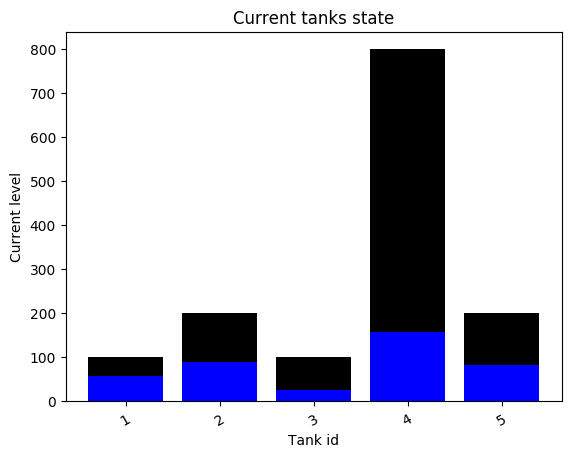

In [31]:
test_Q()
#print(np.mean(test_rewards_list) )

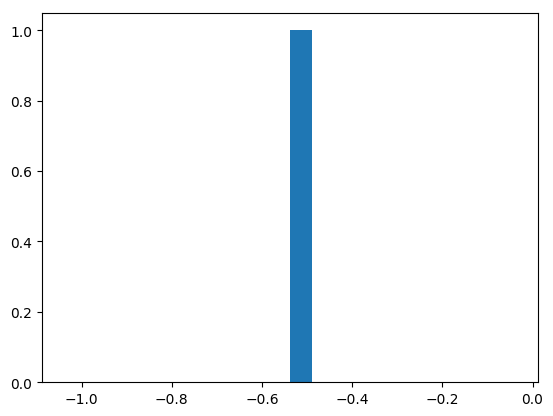

In [32]:
%matplotlib inline
mpl.rcParams.update(mpl.rcParamsDefault)
plt.hist(test_rewards_list, bins = 20)
plt.show()

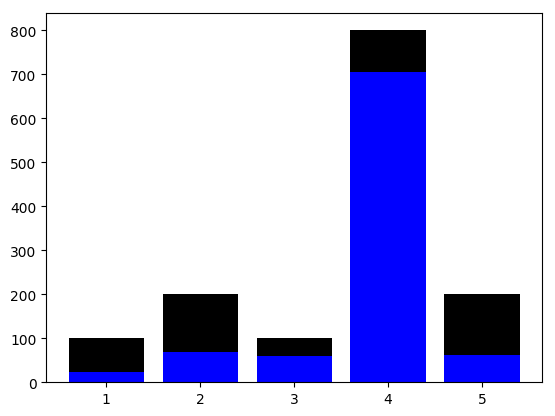

In [33]:
# Visualizing test simulation:

test_anim = ut.create_system_animation(test_visualization_steps, test_episodes * episode_length,test_freq)
HTML(test_anim.to_html5_video())


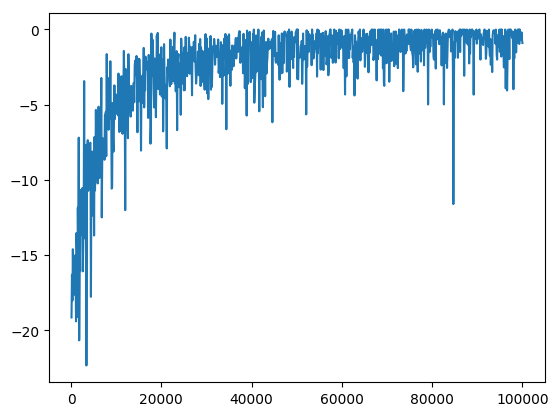

In [34]:
# Visualizing train simulation:

episode =episodes
#simulation_id = 2
step = 30
# discrewards_list = ut.load_obj(simulation_directory+"/discrewards/discrew-train-sim" + f"{simulation_id}" + "-" + f"{episode}")

# discrewards_list2 = [discrewards_list[i] for i in range(0,len(discrewards_list),step)]

# p = plt.plot([i for i in range(0,len(discrewards_list),step)], 
#              discrewards_list2)
# plt.savefig(simulation_directory+'/discrewards-sim' + f'{simulation_id}' + '.png')

discrewards = pd.read_table(rewards_file, sep = ",")

plt.plot(discrewards['episode'],discrewards['discreward'], label = "Discounted rewards")

plt.show()
plt.close()


In [35]:
len(list(Q))

28035

In [18]:
tank_levels = [test_visualization_steps[i][2] for i in range(len(test_visualization_steps))]
tank_levels_array = np.asarray(tank_levels).transpose()

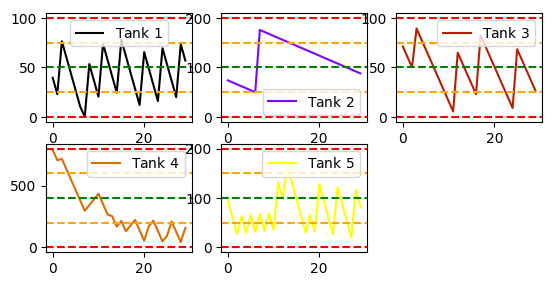

In [19]:
#DISCRETE LEVELS

cmap = plt.get_cmap('gnuplot')
colors = [cmap(i) for i in np.linspace(0, 1, n)]
lvl_colors = ["Orange", "Green","Orange"]

tanks = test_toy_system.tanks

for i, color in enumerate(colors, start=1):
    plt.subplot(3,3, i)    
    plt.plot(tank_levels_array[i-1], color=color, label='Tank ${i}$'.format(i=i))
    
    plt.axhline(y= tanks[i-1].max_load, xmin=0, xmax=episode_length, hold=None, color = "Red", linestyle = '--')
    for lvl_color, lvl in zip(lvl_colors, tanks[i-1].levels):
        plt.axhline(y= lvl, xmin=0, xmax=episode_length, hold=None, color = lvl_color, linestyle = '--')
    plt.axhline(y= 0, xmin=0, xmax=episode_length, hold=None, color = "Red", linestyle = '--')


    plt.legend(loc='best')
plt.show()

        

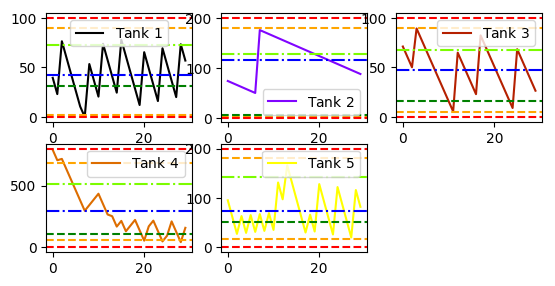

In [20]:
# THE REAL LEVELS (percentages 12h, 36h, ? h)

cmap = plt.get_cmap('gnuplot')
colors = [cmap(i) for i in np.linspace(0, 1, n)]
lvl_colors = ["Orange", "Green","Orange"]

tanks = test_toy_system.tanks

for i, color in enumerate(colors, start=1):
    plt.subplot(3,3, i)    

    plt.plot(tank_levels_array[i-1], color=color, label='Tank ${i}$'.format(i=i))
    
    plt.axhline(y= tanks[i-1].max_load, xmin=0, xmax=episode_length, hold=None, color = "Red", linestyle = '--')
    for lvl_color, lvl in zip(lvl_colors, tanks[i-1].level_percentages):
        plt.axhline(y= lvl * tanks[i-1].max_load, xmin=0, xmax=episode_length, hold=None, color = lvl_color, 
                    linestyle = '--')
    plt.axhline(y= 0, xmin=0, xmax=episode_length, hold=None, color = "Red", linestyle = '--')
    
    
    percentages = tanks[i-1].level_percentages           
    c = percentages[1]
    e = percentages[2]          
    d = ct.p0_GLOBAL*e+(1-ct.p0_GLOBAL)*c
    plt.axhline(y= d*tanks[i-1].max_load, xmin=0, xmax=episode_length, hold=None, color = "lawngreen", 
                linestyle = '-.')

    plt.axhline(y= np.mean(tank_levels_array[i-1]), xmin=0, xmax=episode_length, hold=None, 
                color = "blue", linestyle = '-.')
  


    plt.legend(loc='best')
#plt.show()
plt.savefig(simulation_directory + '/tank-levels-sim' + f'{simulation_id}' + '.pdf')

### Test visualization

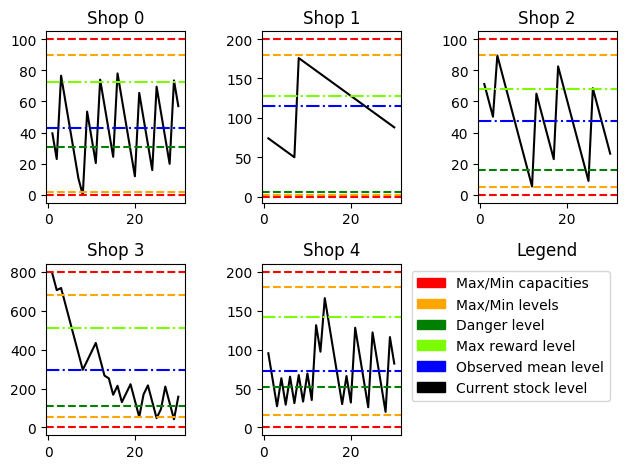

In [38]:
test_states = pd.read_table(states_file, sep = ",")
test_states.head()


cmap = plt.get_cmap('gnuplot')
colors = [cmap(i) for i in np.linspace(0, 1, n)]
lvl_colors = ["Orange", "Green","Orange"]

tanks = test_toy_system.tanks

for i, color in enumerate(colors, start=1):    
    plt.subplot(2,3,i)
    states = test_states['stock{}'.format(i-1)]
    plt.plot(test_states['step'],states, label = "Shop {}".format(i-1), color = "Black")
    plt.title("Shop {}".format(i-1))
    
    plt.axhline(y= tanks[i-1].max_load, xmin=0, xmax=episode_length, hold=None, color = "Red", linestyle = '--')
    for lvl_color, lvl in zip(lvl_colors, tanks[i-1].level_percentages):
        plt.axhline(y= lvl * tanks[i-1].max_load, xmin=0, xmax=episode_length, hold=None, color = lvl_color, 
                    linestyle = '--')
    plt.axhline(y= 0, xmin=0, xmax=episode_length, hold=None, color = "Red", linestyle = '--')
    
    
    percentages = tanks[i-1].level_percentages           
    c = percentages[1]
    e = percentages[2]          
    d = ct.p0_GLOBAL*e+(1-ct.p0_GLOBAL)*c
    plt.axhline(y= d*tanks[i-1].max_load, xmin=0, xmax=episode_length, hold=None, color = "lawngreen", 
                linestyle = '-.')

    plt.axhline(y= np.mean(states), xmin=0, xmax=episode_length, hold=None, 
                color = "blue", linestyle = '-.')
 
plt.subplot(2,3,6)
plt.title("Legend")
plt.axis('off')

#plt.legend(bbox_to_anchor=(0.5 ,0.8), loc=2, borderaxespad=0.)
plt.yticks([])
plt.xticks([])

patch1 = mpatches.Patch(color='red', label='Max/Min capacities')
patch2 = mpatches.Patch(color='orange', label='Max/Min levels')
patch3 = mpatches.Patch(color='green', label='Danger level')
patch4 = mpatches.Patch(color='lawngreen', label='Max reward level')
patch5 = mpatches.Patch(color='blue', label='Observed mean level')
patch6 = mpatches.Patch(color='black', label='Current stock level')


plt.legend(handles=[patch1, patch2, patch3, patch4, patch5, patch6])

plt.tight_layout() 
plt.show()
plt.close()